# Learning parameters via Bayes Rule in a simple non-linear ODE

In this notebook, I show how to learn parameters in a simple non-linear ODE using Bayesian statistics.

The ODE we will look at is the Lotka-Volterra model:
$$\begin{align}
 \frac{dx}{dt} &= \alpha x - \beta x y, \\
 \frac{dy}{dt} &= \delta x y - \gamma y,
\end{align}$$
Where $x$ is the quantity of a prey species and $y$ is the quantity of a predator species. The other symbols, $\alpha, \beta, \gamma$ and $\delta$, are fixed parameters.

More precisely, we will look at a stochastic version of these equations which is 'clipped'. That is, 
$$\begin{align}
 \frac{dx}{dt} &= \alpha x - \beta x y + \epsilon_x, \\
 \frac{dy}{dt} &= \delta x y - \gamma y + \epsilon_y,
\end{align}$$
where $\epsilon = (\epsilon_x, \epsilon_y)$ is drawn from a 2-dimensional normal distribution. The clipped aspect is that we disallow negative values for either of $x$ and $y$.

## Creating some data

In lieu of real world data, we will begin with a simulated trajectory using known constants.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import itertools

In [2]:
# constants for Lotka-Volterra
alpha_star = 2/3
beta_star = 4/3
gamma_star = 1
delta_star = 1
# stochasticity
epsilon_star = 0.1

### Create the stochastic update (Euler's method with clipping)

In [3]:
def update(state, *, dt, alpha, beta, gamma, delta, epsilon):
    return np.clip(
        state 
        + dt * (
            np.array( [ state[0] * ( alpha -     beta * state[1] ),
                        state[1] * ( delta * state[0] -    gamma ) ] )
            + np.random.normal(scale=epsilon, size=state.shape)
        ),
        0.0,
        float('inf'),
    )

In [4]:
def make_trajectory(*, initial_condition, dt, tmax, alpha, beta, gamma, delta, epsilon):
    time_series = [initial_condition]

    state = initial_condition
    for _  in range(int(tmax/dt)):
        state = update(state, 
                       dt=dt, 
                       alpha=alpha,
                       beta=beta,
                       gamma=gamma,
                       delta=delta,
                       epsilon=epsilon
                      )
        time_series.append(state)

    return np.array(time_series)

### Plot a family of trajectories

Before creating the specific trajectory that will be learned, we plot a few trajectories to see how stochasitcity works in this context.

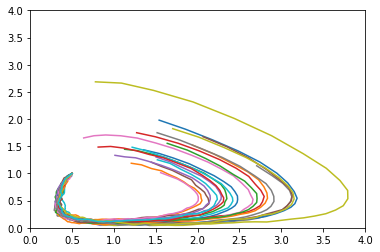

In [5]:
initial_condition = np.array([[0.5]*20,[1.0]*20])

time_series = make_trajectory(
    initial_condition=initial_condition,
    dt=0.1, 
    tmax=50,
    alpha=alpha_star,
    beta=beta_star,
    gamma=gamma_star,
    delta=delta_star,
    epsilon=epsilon_star
)

plt.figure()
lines = plt.plot(time_series[:75,0,:],time_series[:75,1,:])
_ = plt.xlim([0,4])
_ = plt.ylim([0,4])

### Create and plot our simulated data for learning

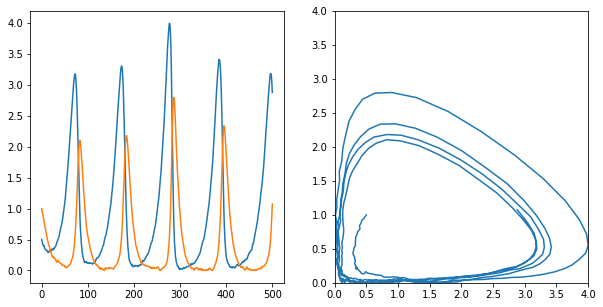

In [6]:
time_series = make_trajectory(
    initial_condition=np.array([0.5,1.0]),
    dt=0.1, 
    tmax=50,
    alpha=alpha_star,
    beta=beta_star,
    gamma=gamma_star,
    delta=delta_star,
    epsilon=epsilon_star
)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(time_series[:,0])
plt.plot(time_series[:,1])

plt.subplot(122)
plt.plot(time_series[:,0],time_series[:,1])
plt.xlim([0,4])
plt.ylim([0,4])

plt.show()

# Goal: Learn $\beta$

I am going to do a non-parametric version here with uniform prior, where we have several candidate values for $\beta$ which cover a reasonable range $\beta\in[0,3]$.

One can also suppose that $\beta$'s prior distribution is e.g. normal. https://en.wikipedia.org/wiki/Conjugate_prior 

In [14]:
beta_bins = 19
betas = np.linspace(0, 3, num=beta_bins)
betas_dist = np.full(beta_bins, 1/beta_bins)

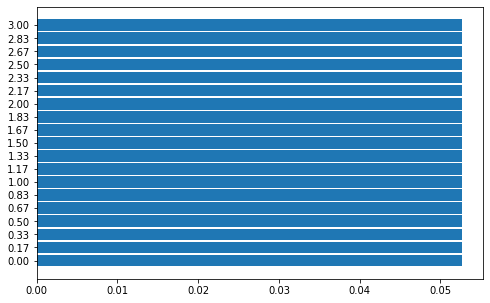

In [15]:
# plot a uniform distribution

plt.figure(figsize=(8,5))
plt.barh(y=betas,
         width=betas_dist,
         height=0.15,
         tick_label=list(map(lambda x: "{:.2f}".format(x), betas)))
plt.show()

# Learning step.

(TODO: make notation better)

This is based on Bayes' rule:
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$
in particular, we want to think of $A$ as being $\beta=$some value and $B$ as being the evidence. (observation of our data) We will largely ignore $P(B)$ as it is constant over all $A$ and can be considered merely a normalizing constant.

The interesting computation/simulation comes in for the computation of $P(B|A)$ i.e. the probability of seeing our evidence given a hyopthesis about the parameter. To estimate this probability, we need to run the simulator (the stochastic ODE) a number of times, calculate a probability distribution, and compute the probability of the evidence under that distribution.

I will make a simplifying assumption that $P(B|A)$ is normally distributed.

Concretely, in this simplified example, we will loop over each of the possible values for $\beta$. For each of them, we generate `num_trajectories` number of trajectories. We then fit a multivariate normal distribution to the first `to_compare` time steps and calculate the (point) probability of the evidence under that distribution.

In [16]:
to_compare = 4 # number of data points from time series to compare
num_trajectories = 1_000

for beta_idx in range(len(betas)):
    beta = betas[beta_idx]
    beta_prob = betas_dist[beta_idx]

    trial_trajectories = make_trajectory(
        initial_condition=np.array([[0.5]*num_trajectories,[1.0]*num_trajectories]),
        dt=0.1, 
        tmax=0.1*(to_compare+1),
        alpha=alpha_star,
        beta=beta,
        gamma=gamma_star,
        delta=delta_star,
        epsilon=epsilon_star
    )[1:,:,:]
    
    means = np.mean(trial_trajectories,axis=2).reshape(-1)
    covs = np.cov(trial_trajectories.reshape((-1,trial_trajectories.shape[-1])))
    
    # just so we all know, this number can be > 1. This is OK and will get normalized out.
    evidence_prob = multivariate_normal.pdf(time_series[1:to_compare+2,:].reshape(-1), mean=means, cov=covs) 
    
    betas_dist[beta_idx] = evidence_prob * beta_prob
    
betas_dist /= np.sum(betas_dist)

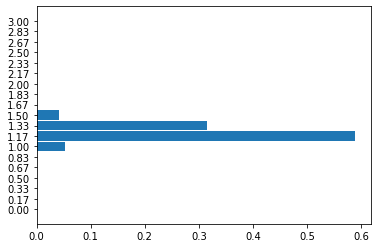

In [17]:
plt.barh(y=betas,
         width=betas_dist,
         height=0.15,
         tick_label=list(map(lambda x: "{:.2f}".format(x), betas)))
plt.show()

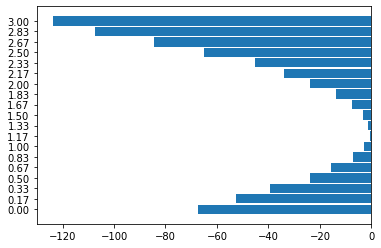

In [18]:
plt.barh(y=betas,
         width=np.log(betas_dist),
         height=0.15,
         tick_label=list(map(lambda x: "{:.2f}".format(x), betas)))
plt.show()

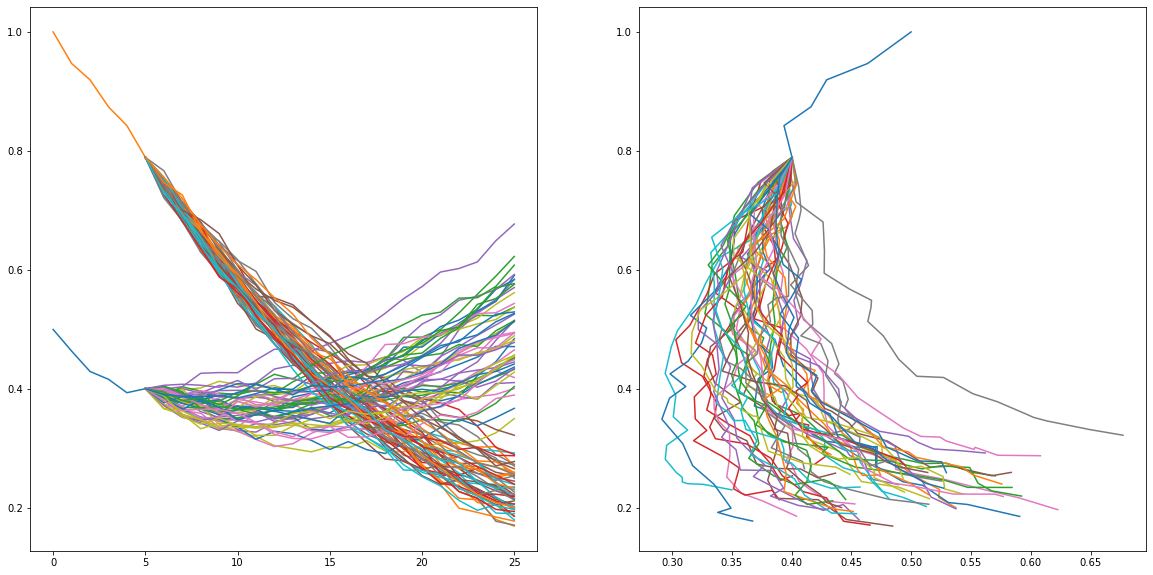

In [19]:
extension_length = 20

cdf = np.cumsum(betas_dist.ravel())

initial_part_traj = time_series[:to_compare+2,:]

trajectories = []

fig = plt.figure(figsize=(20,10))
xy_plot, phase_plot = fig.subplots(1,2).reshape(-1)


xy_plot.plot(range(0,to_compare+2), initial_part_traj[:,0])
xy_plot.plot(range(0,to_compare+2), initial_part_traj[:,1])

phase_plot.plot(*initial_part_traj.T)

for _ in range(50):
    prob_idx = np.unravel_index(np.argmax(np.random.uniform() <= cdf), betas_dist.shape)
    beta = betas[prob_idx]
    
    rest_of_traj = make_trajectory(
        initial_condition=time_series[to_compare+1,:],
        dt=0.1, 
        tmax=0.1*extension_length,
        alpha=alpha_star,
        beta=beta,
        gamma=gamma_star,
        delta=delta_star,
        epsilon=epsilon_star
    )
    
    xy_plot.plot(range(to_compare+1, to_compare+2+extension_length), rest_of_traj[:,0])
    xy_plot.plot(range(to_compare+1, to_compare+2+extension_length), rest_of_traj[:,1])
    
    phase_plot.plot(*rest_of_traj.T)
    
plt.show()

## Visualizations

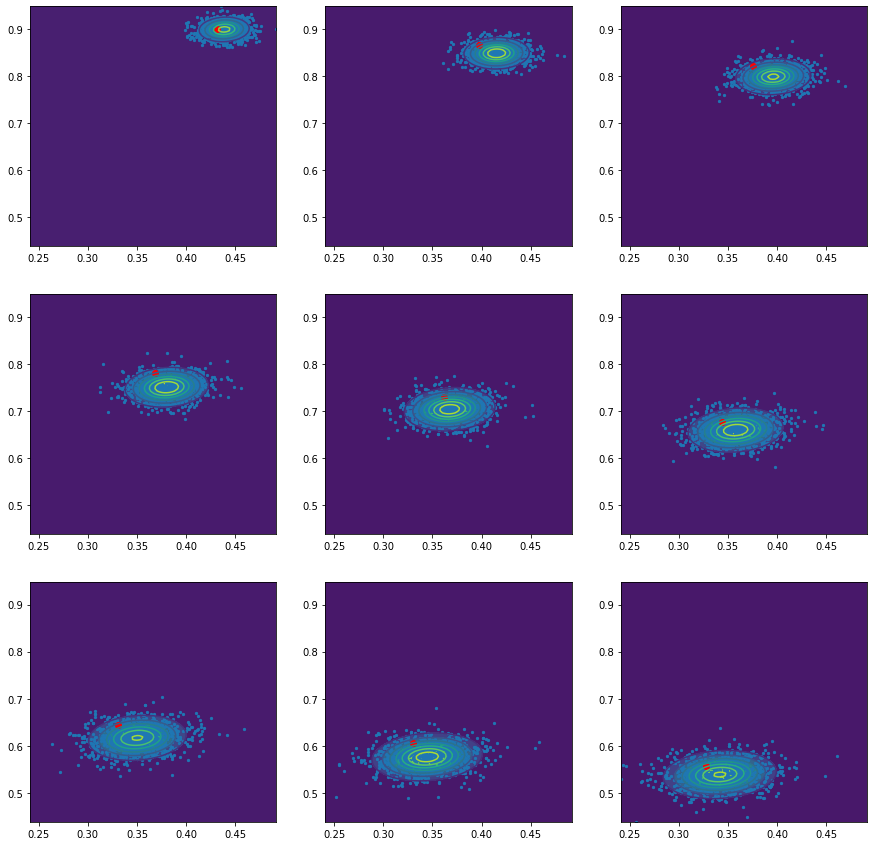

In [19]:
# where the real trajectory lies (per time) for beta=4/3 (correct beta)

idx_min = 2
idx_max = 10

num_trajectories = 1_000
trial_trajectories = make_trajectory(
    initial_condition=np.array([[0.5]*num_trajectories,[1.0]*num_trajectories]),
    dt=0.1, 
    tmax=0.1*idx_max,
    alpha=alpha_star,
    beta=4/3,
    gamma=gamma_star,
    delta=delta_star,
    epsilon=epsilon_star
)

fig = plt.figure(figsize=(15,15))
subplots = fig.subplots(3,3).reshape(-1)

for plot_idx, idx in enumerate(range(idx_min,idx_max+1)):
    mean = np.mean(trial_trajectories[idx,:,:], axis=1)
    cov = np.cov(trial_trajectories[idx,:,:], rowvar=1)
    
    min_x = np.min([np.min(time_series[idx_min:(idx_max+1),0],), np.min(trial_trajectories[idx_min:(idx_max+1),0,:])])
    max_x = np.max([np.max(time_series[idx_min:(idx_max+1),0],), np.max(trial_trajectories[idx_min:(idx_max+1),0,:])])
    min_y = np.min([np.min(time_series[idx_min:(idx_max+1),1],), np.min(trial_trajectories[idx_min:(idx_max+1),1,:])])
    max_y = np.max([np.max(time_series[idx_min:(idx_max+1),1],), np.max(trial_trajectories[idx_min:(idx_max+1),1,:])])
    
    x, y = np.mgrid[min_x:max_x:100j,
                    min_y:max_y:100j]
    pos = np.dstack((x, y))
    zv = multivariate_normal.pdf(pos, mean=mean, cov=cov)
    subplots[plot_idx].contourf(x, y, zv)
    subplots[plot_idx].scatter(*trial_trajectories[idx,:,:], s=5)
    subplots[plot_idx].contour(x, y, zv)
    subplots[plot_idx].scatter(*time_series[idx,:], color='r')
    
plt.show()

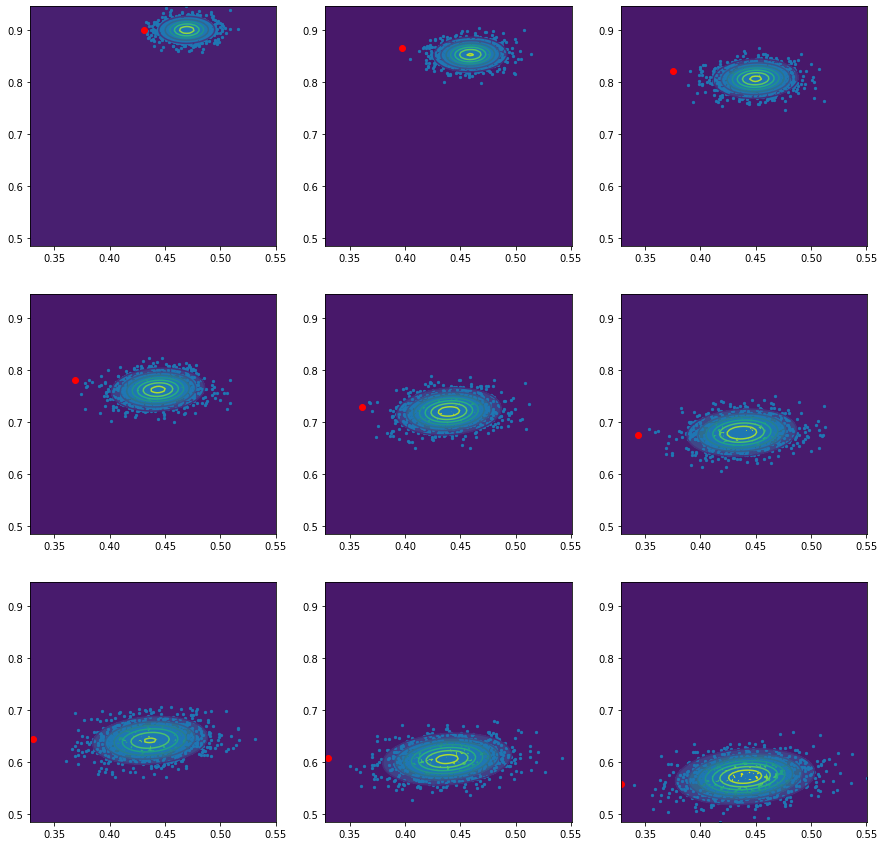

In [20]:
# where the real trajectory lies (per time) for beta=1 (incorrect beta)

idx_min = 2
idx_max = 10

num_trajectories = 1_000
trial_trajectories = make_trajectory(
    initial_condition=np.array([[0.5]*num_trajectories,[1.0]*num_trajectories]),
    dt=0.1, 
    tmax=0.1*idx_max,
    alpha=alpha_star,
    beta=1.0,
    gamma=gamma_star,
    delta=delta_star,
    epsilon=epsilon_star
)

fig = plt.figure(figsize=(15,15))
subplots = fig.subplots(3,3).reshape(-1)

for plot_idx, idx in enumerate(range(idx_min,idx_max+1)):
    mean = np.mean(trial_trajectories[idx,:,:], axis=1)
    cov = np.cov(trial_trajectories[idx,:,:], rowvar=1)
    
    min_x = np.min([np.min(time_series[idx_min:(idx_max+1),0],), np.min(trial_trajectories[idx_min:(idx_max+1),0,:])])
    max_x = np.max([np.max(time_series[idx_min:(idx_max+1),0],), np.max(trial_trajectories[idx_min:(idx_max+1),0,:])])
    min_y = np.min([np.min(time_series[idx_min:(idx_max+1),1],), np.min(trial_trajectories[idx_min:(idx_max+1),1,:])])
    max_y = np.max([np.max(time_series[idx_min:(idx_max+1),1],), np.max(trial_trajectories[idx_min:(idx_max+1),1,:])])
    
    x, y = np.mgrid[min_x:max_x:100j,
                    min_y:max_y:100j]
    pos = np.dstack((x, y))
    zv = multivariate_normal.pdf(pos, mean=mean, cov=cov)
    subplots[plot_idx].contourf(x, y, zv)
    subplots[plot_idx].scatter(*trial_trajectories[idx,:,:], s=5)
    subplots[plot_idx].contour(x, y, zv)
    subplots[plot_idx].scatter(*time_series[idx,:], color='r')

# Goal 2: Learn joint distribution of $\beta$ and $\delta$

In [23]:
beta_bins = 19
delta_bins = 19

betas, deltas = np.mgrid[0:3: beta_bins * 1j,
                         0:3:delta_bins * 1j]

prob_dist = np.full(beta_bins*delta_bins, 1/(beta_bins*delta_bins)).reshape((beta_bins, delta_bins))

In [24]:
to_compare = 2 # number of data points from time series to compare
num_trajectories = 1000

for beta_idx, delta_idx in itertools.product(range(beta_bins), range(delta_bins)):
    beta = betas[beta_idx, delta_idx]
    delta = deltas[beta_idx, delta_idx]
    
    prior_prob = prob_dist[beta_idx, delta_idx]

    trial_trajectories = make_trajectory(
        initial_condition=np.array([[0.5]*num_trajectories,[1.0]*num_trajectories]),
        dt=0.1, 
        tmax=0.1*(to_compare+1),
        alpha=alpha_star,
        beta=beta,
        gamma=gamma_star,
        delta=delta,
        epsilon=epsilon_star
    )[1:,:,:]
    
    means = np.mean(trial_trajectories,axis=2).reshape(-1)
    covs = np.cov(trial_trajectories.reshape((-1,trial_trajectories.shape[-1])))
    
    # just so we all know, this number can be > 1. This is OK and will get normalized out.
    evidence_prob = multivariate_normal.pdf(time_series[1:to_compare+2,:].reshape(-1), mean=means, cov=covs) 
    
    prob_dist[beta_idx,delta_idx] = evidence_prob * prior_prob
    
prob_dist /= np.sum(prob_dist)

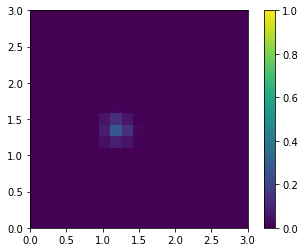

In [25]:
plt.figure()
plt.imshow(prob_dist[::-1,:], vmin=0.0, vmax=1.0, extent=(0,3,0,3))
plt.colorbar()
plt.show()

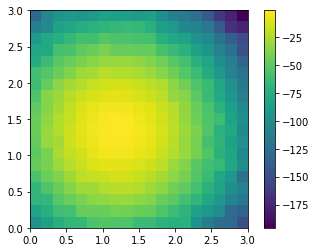

In [26]:
# take the log, so that we can see the variation better

plt.figure()
with np.errstate(divide='ignore'):
    plt.imshow(np.log(prob_dist[::-1,:]), extent=(0,3,0,3))
plt.colorbar()
plt.show()

In [39]:
best_prob_idx = np.unravel_index(np.argmax(prob_dist, axis=None), prob_dist.shape)
print( f"{betas[best_prob_idx]=}, {deltas[best_prob_idx]=}" )

betas[best_prob_idx]=1.3333333333333333, deltas[best_prob_idx]=1.0


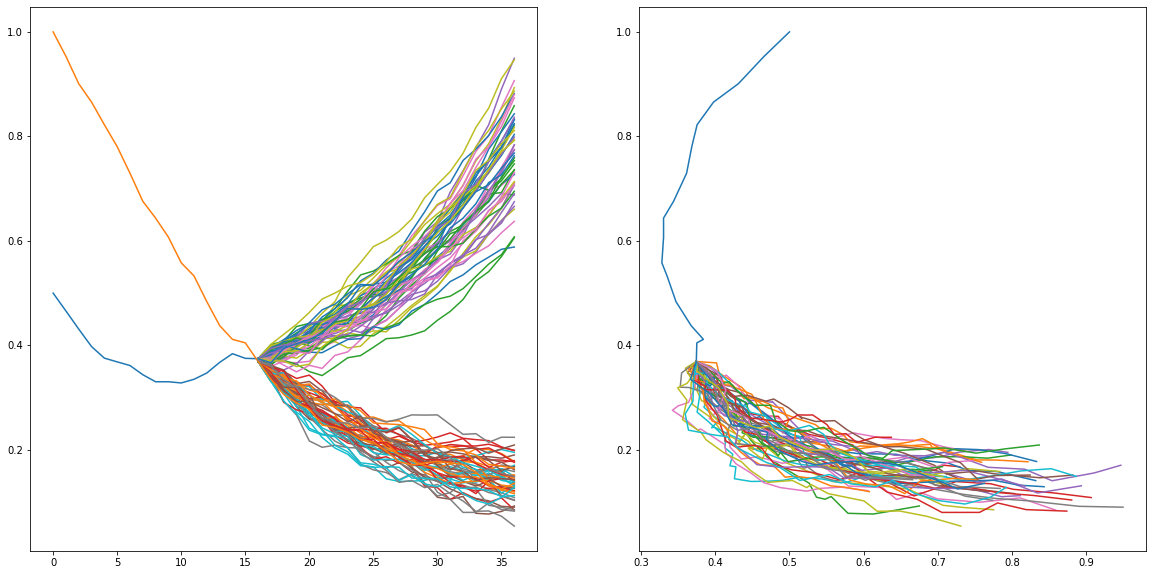

In [40]:
extension_length = 20

cdf = np.cumsum(prob_dist.ravel())

initial_part_traj = time_series[:to_compare+2,:]

trajectories = []

fig = plt.figure(figsize=(20,10))
xy_plot, phase_plot = fig.subplots(1,2).reshape(-1)


xy_plot.plot(range(0,to_compare+2), initial_part_traj[:,0])
xy_plot.plot(range(0,to_compare+2), initial_part_traj[:,1])

phase_plot.plot(*initial_part_traj.T)

for _ in range(50):
    prob_idx = np.unravel_index(np.argmax(np.random.uniform() <= cdf), prob_dist.shape)
    beta = betas[prob_idx]
    delta = deltas[prob_idx]
    
    rest_of_traj = make_trajectory(
        initial_condition=time_series[to_compare+1,:],
        dt=0.1, 
        tmax=0.1*extension_length,
        alpha=alpha_star,
        beta=beta,
        gamma=gamma_star,
        delta=delta,
        epsilon=epsilon_star
    )
    
    xy_plot.plot(range(to_compare+1, to_compare+2+extension_length), rest_of_traj[:,0])
    xy_plot.plot(range(to_compare+1, to_compare+2+extension_length), rest_of_traj[:,1])
    
    phase_plot.plot(*rest_of_traj.T)
    
plt.show()

In [41]:
for _ in range(50):
    prob_idx = np.unravel_index(np.argmax(np.random.uniform() <= cdf), prob_dist.shape)
    beta = betas[prob_idx]
    delta = deltas[prob_idx]
    print(f"{beta=} {delta=}")

beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.5 delta=1.0
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.1666666666666665 delta=1.1666666666666665
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.0
beta=1.5 delta=1.0
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.3333333333333333 delta=1.1666666666666665
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=1.0
beta=1.3333333333333333 delta=